In [1]:
import torch
import torch.nn as nn
from PIL import Image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import json
from encoder import ImageEncoder
from decoder import CaptionDecoder

In [39]:
class ImageCaptionTester:
    def __init__(self, model_path='Models/captioning_model.pth'):
        """Initialize the tester with trained model"""
        
        # Load metadata thay vì vocab_info
        try:
            with open('Processed Data/metadata.json', 'r') as f:
                metadata = json.load(f)
            
            # Load vocab để lấy special tokens
            with open('Processed Data/vocab.json', 'r') as f:
                vocab = json.load(f)
            
            # Tạo vocab_info từ metadata và vocab
            self.vocab_info = {
                'vocab_size': metadata['vocab_size'],
                'max_length': metadata['max_length'],
                'start_token': vocab['<START>'],
                'end_token': vocab['<END>'],
                'pad_token': vocab['<PAD>'],
                'unk_token': vocab['<UNK>']
            }
            
            print(f"✅ Loaded metadata: vocab_size={self.vocab_info['vocab_size']}")
            
        except FileNotFoundError as e:
            print(f"❌ File not found: {e}")
            print("📂 Available files in Processed Data:")
            import os
            if os.path.exists('Processed Data'):
                for file in os.listdir('Processed Data'):
                    print(f"   {file}")
            raise
            
        # Initialize models
        self.encoder = ImageEncoder(embed_dim=512)
        self.decoder = CaptionDecoder(self.vocab_info['vocab_size'], embed_dim=512)
        
        # Load device
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.encoder.to(self.device)
        self.decoder.to(self.device)
        
        # Load trained weights
        try:
            checkpoint = torch.load(model_path, map_location=self.device)
            self.encoder.load_state_dict(checkpoint['encoder_state'])
            self.decoder.load_state_dict(checkpoint['decoder_state'])
            print(f"✅ Model loaded from {model_path}")
        except Exception as e:
            print(f"❌ Error loading model: {e}")
            # List available checkpoint files
            for file in os.listdir('.'):
                if file.endswith('.pth'):
                    print(f"   Available: {file}")
            raise
        
        # Set to eval mode
        self.encoder.eval()
        self.decoder.eval()
        
        # Image preprocessing (same as training)
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                               std=[0.229, 0.224, 0.225])
        ])
        
    def decode_caption(self, caption_ids):
        """Convert caption IDs back to text"""
        with open('Processed Data/decode_vocab.json', 'r') as f:
            decode_vocab = json.load(f)
        
        words = []
        for idx in caption_ids:
            word = decode_vocab[str(idx)]
            if word not in ['<START>', '<END>', '<PAD>']:
                words.append(word)
        
        return ' '.join(words)
    
    def generate_caption(self, image_tensor, max_length=20, temperature=1.2):
        """Generate caption for image"""
        with torch.no_grad():
            # Extract image features
            image_features = self.encoder(image_tensor.unsqueeze(0).to(self.device))
            
            # Start with START token
            caption = [self.vocab_info['start_token']]
            
            for _ in range(max_length):
                caption_tensor = torch.tensor([caption]).to(self.device)
                outputs = self.decoder(caption_tensor, image_features)
                
                # Temperature sampling
                logits = outputs[0, -1, :] / temperature
                
                # Mask UNK token để giảm xác suất
                unk_idx = self.vocab_info['unk_token']
                logits[unk_idx] = logits[unk_idx] - 2.0  # Penalty cho UNK
                
                probs = torch.softmax(logits, dim=-1)
                
                # Sample từ top-k
                top_k = 10
                top_probs, top_indices = torch.topk(probs, top_k)
                top_probs = top_probs / top_probs.sum()  # Normalize
                
                next_word_idx = torch.multinomial(top_probs, 1).item()
                next_word = top_indices[next_word_idx].item()
                
                caption.append(next_word)
                
                # Stop if END token
                if next_word == self.vocab_info['end_token']:
                    break
        
        return caption
    
    def predict_image(self, image_path):
        """Predict caption for any image"""
        try:
            # Load and preprocess image
            print(f"🖼️ Loading image: {image_path}")
            image = Image.open(image_path).convert('RGB')
            image_tensor = self.transform(image)
            
            print("🤖 Generating captions...")
            # Method 2: Temperature sampling
            predicted_caption = self.generate_caption(image_tensor, temperature=1.2)
            predicted_text = self.decode_caption(predicted_caption)
            
            # Display result
            plt.figure(figsize=(12, 8))
            plt.imshow(image)
            plt.axis('off')
            plt.title(predicted_text, 
                    fontsize=14, fontweight='bold')
            plt.tight_layout()
            plt.show()
            
            return predicted_text
            
        except Exception as e:
            print(f"❌ Error: {e}")
        return None

# Initialize tester
import os
print("📂 Checking files...")
if os.path.exists('Processed Data'):
    print("Files in Processed Data:")
    for file in os.listdir('Processed Data'):
        print(f"   ✅ {file}")
else:
    print("❌ Processed Data folder not found!")

print("\nCheckpoint files:")
for file in os.listdir('.'):
    if file.endswith('.pth'):
        print(f"   ✅ {file}")

tester = ImageCaptionTester()

📂 Checking files...
Files in Processed Data:
   ✅ decode_vocab.json
   ✅ metadata.json
   ✅ test_sequences.pkl
   ✅ train_sequences.pkl
   ✅ val_sequences.pkl
   ✅ vocab.json

Checkpoint files:
✅ Loaded metadata: vocab_size=2549
✅ Model loaded from Models/captioning_model.pth


🖼️ Loading image: Flickr8k/Flicker8k_Dataset/44856031_0d82c2c7d1.jpg
🤖 Generating captions...


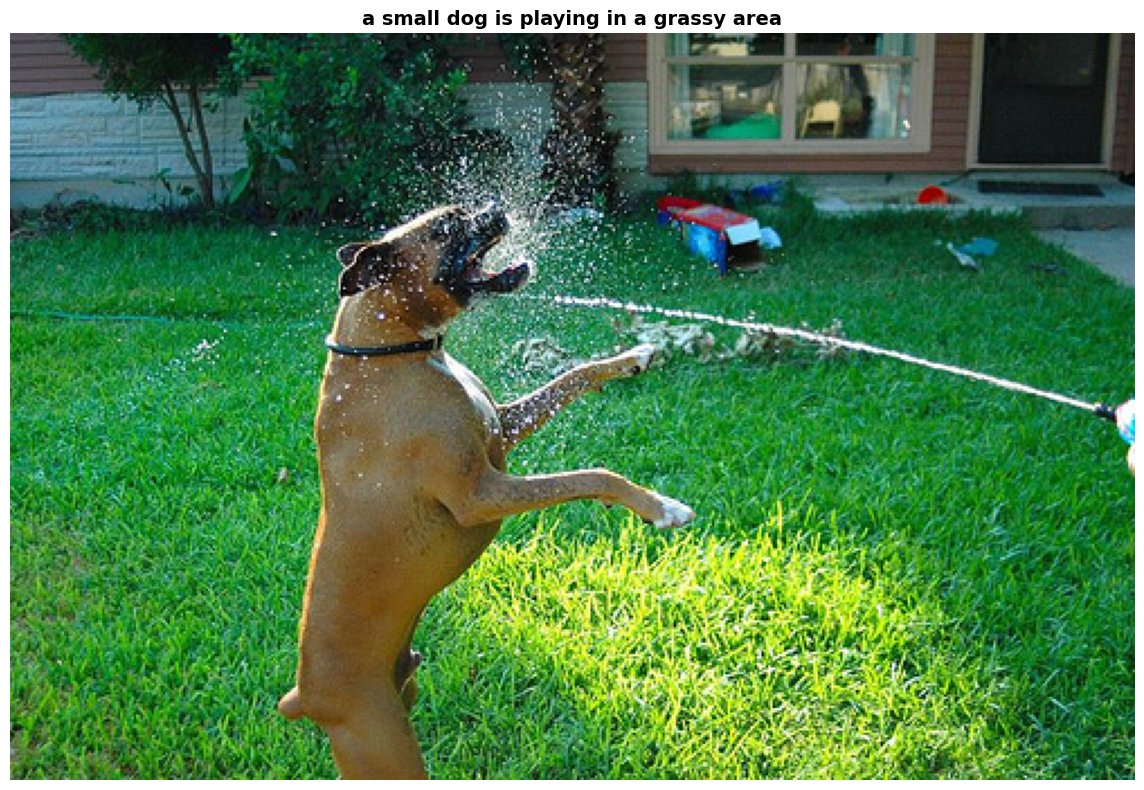

'a small dog is playing in a grassy area'

In [50]:
def test_single_image(image_path):
    """Simple function to test one image"""
    return tester.predict_image(image_path)

# Example usage - thay đường dẫn ảnh của bạn
image_path = "Flickr8k/Flicker8k_Dataset/44856031_0d82c2c7d1.jpg" 
test_single_image(image_path)

In [20]:
# Test với ảnh từ URL (bonus)
def test_from_url(url):
    """Test image from URL"""
    import requests
    from io import BytesIO
    
    try:
        print(f"📥 Downloading image from: {url}")
        response = requests.get(url)
        image = Image.open(BytesIO(response.content)).convert('RGB')
        
        # Save temporarily
        temp_path = "temp_image.jpg"
        image.save(temp_path)
        
        # Test
        caption = test_single_image(temp_path)
        
        # Clean up
        import os
        os.remove(temp_path)
        
        return caption
        
    except Exception as e:
        print(f"❌ Error downloading image: {e}")
        return None

# Example URL test
# url = "https://example.com/image.jpg"
# test_from_url(url)

📥 Downloading image from: https://tensorflow.org/images/surf.jpg
🖼️ Loading image: temp_image.jpg
🤖 Generating captions...


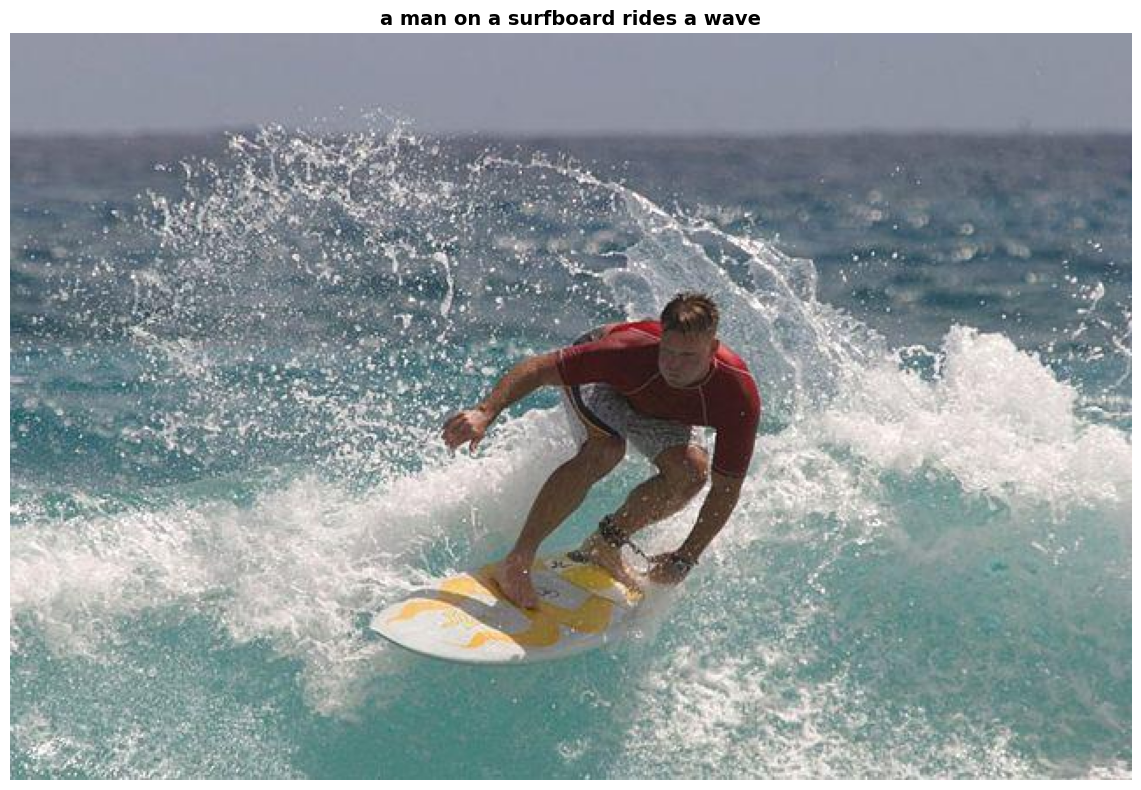

'a man on a surfboard rides a wave'

In [38]:
url = "https://tensorflow.org/images/surf.jpg"
test_from_url(url)